In [460]:
import re
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from collections import defaultdict
from scipy.linalg import eigh
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Read in data and filter on political subreddits

In [461]:
# load the data
df = pd.read_csv("data/filtered_network.csv")

In [462]:
# Create the adjacency matrix from the filtered DataFrame
source = "SOURCE_SUBREDDIT"
target = "TARGET_SUBREDDIT"
edgelist = df.loc[:, [source, target]].copy()
edgelist_df = edgelist.drop_duplicates().copy()
edgelist_df["count"] = edgelist.groupby([source, target]).transform("size")
# create graph
G = nx.from_pandas_edgelist(edgelist_df, source=source, target=target, create_using=nx.Graph(),edge_attr="count")

#### Plot the graph

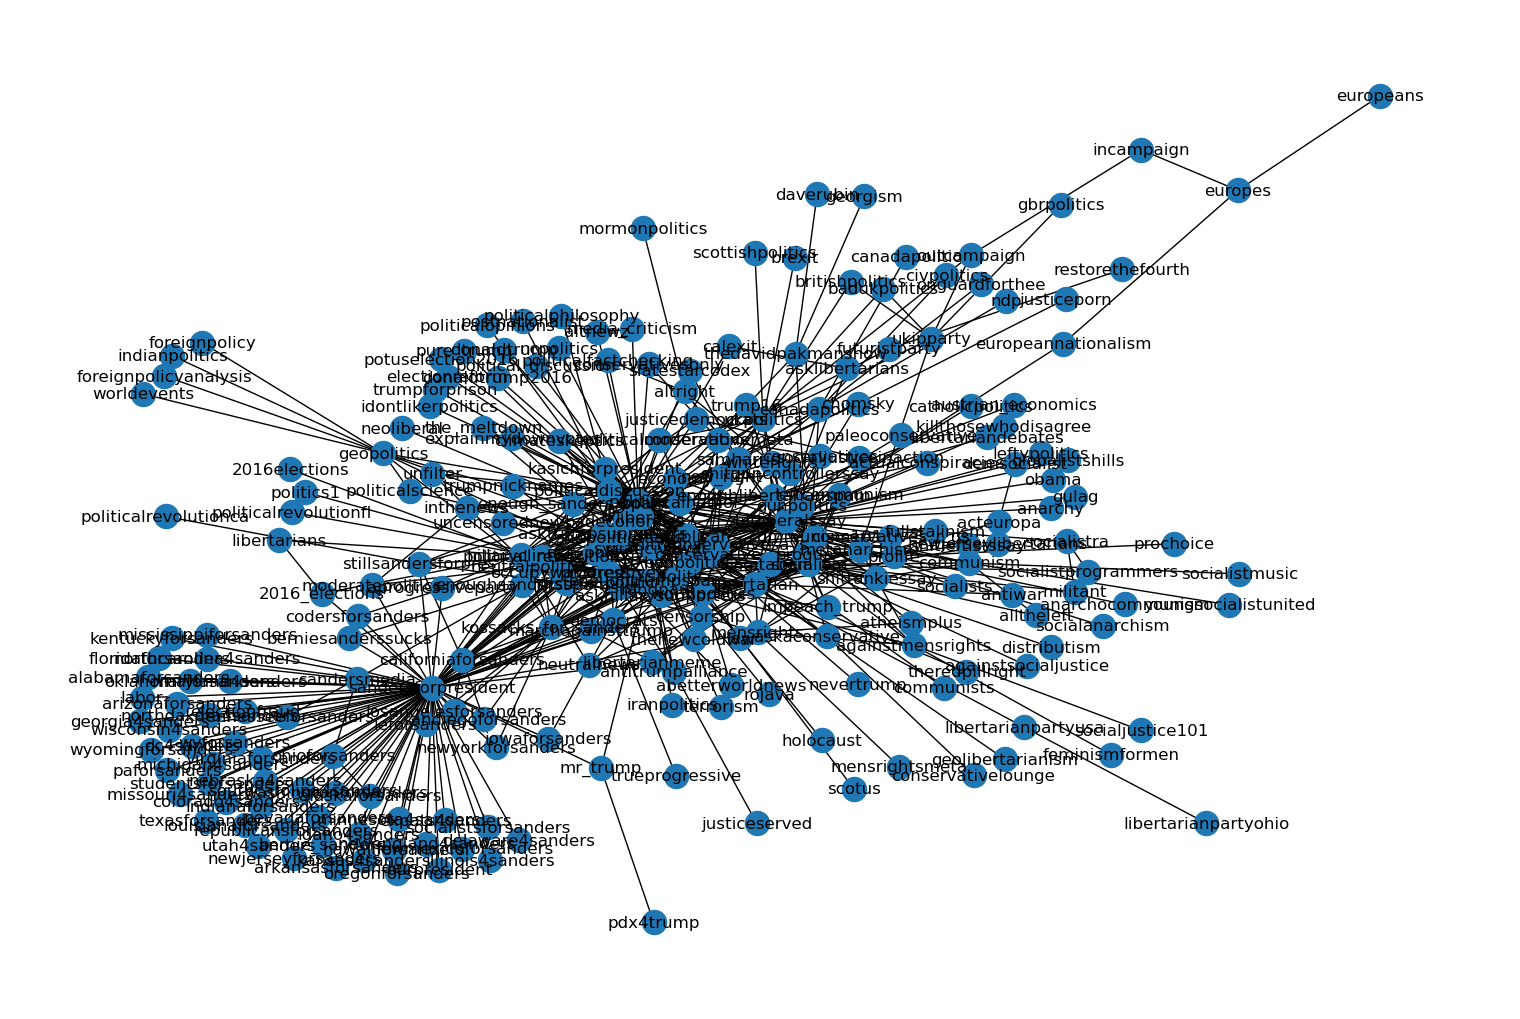

In [463]:
plt.figure(figsize=(15,10))
nx.draw(G, with_labels=True)
plt.show()

In [464]:
# get adjacency matrix
adj_matrix =  nx.to_pandas_adjacency(G, weight='count')

print("Adjacency Matrix:")
adj_matrix

Adjacency Matrix:


,libertarian,conservative,communism101,communism,mensrightsmeta,mensrights,politicaldiscussion,politics,socialism,postnationalist,...,esist,socialjustice101,globalistshills,conservativelounge,daverubin,neoliberal,theredpillright,holocaust,bernie_sanders,georgism
libertarian,0.0,6.0,0.0,0.0,0.0,1.0,3.0,16.0,9.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
conservative,6.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
communism101,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
communism,0.0,0.0,5.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mensrightsmeta,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
neoliberal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
theredpillright,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
holocaust,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bernie_sanders,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [465]:
degree_matrix = np.diag(adj_matrix.sum(axis=1))
d_max = np.max(np.diag(degree_matrix))
delta_values = [0.01, 0.05, 0.1, 0.5, 1]
laplacians = []
for delta in delta_values:
    d_max = np.max(degree_matrix)
    ridge_regularization = degree_matrix + delta * d_max * np.eye(adj_matrix.shape[0])
    sqrt_inv = np.linalg.inv(np.sqrt(ridge_regularization))
    laplacian_prime = sqrt_inv @ adj_matrix @ sqrt_inv
    laplacians.append(laplacian_prime)

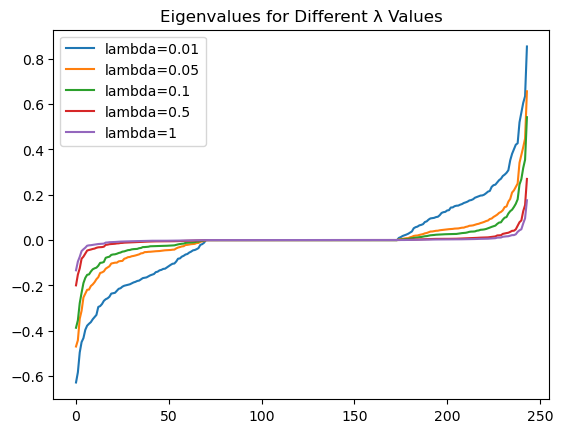

In [466]:
for i, laplacian in enumerate(laplacians):
    eigenvalues, _ = np.linalg.eigh(laplacian)
    plt.plot(eigenvalues, label=f'lambda={delta_values[i]}')
plt.legend()
plt.title('Eigenvalues for Different λ Values')
plt.show()

## Perform SCORE+ community detection

In [467]:
# Inputs
delta = 0.05  # Ridge regularization parameter
t = 0.10  # Signal weakness threshold
K = 6 # Initial number of clusters

#### Step 1: Pre-PCA Normalization with Laplacian

In [468]:
n = adj_matrix.shape[0]
D = np.diag(adj_matrix.sum(axis=1)) 
d_max = np.max(np.diag(D)) 
ridge_regularization = D + delta * d_max * np.eye(n)
sqrt_inv = np.linalg.inv(np.sqrt(ridge_regularization))
L_delta = sqrt_inv @ adj_matrix @ sqrt_inv

#### Step 2: PCA and Signal Weakness Test

In [469]:
eigenvalues, eigenvectors = np.linalg.eigh(L_delta)
sorted_indices = np.argsort(eigenvalues)[::-1] 
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Signal weakness test
if eigenvalues[K] / eigenvalues[K - 1] <= t:
    M = K + 1
else:
    M = K

print("Number of clusters:", M)

Number of clusters: 6


#### Step 3: Post-PCA Normalization

In [470]:
R_hat = []
epsilon = 1e-9  

eta_1 = eigenvalues[0] * eigenvectors[:, 0]

for k in range(1, M):
    eta_k = eigenvalues[k] * eigenvectors[:, k] 
    normalized_eta_k = eta_k / (eta_1 + epsilon)
    R_hat.append(normalized_eta_k)

R_hat = np.column_stack(R_hat)

#### Step 4: Clustering on the rows of R_hat

In [471]:
kmeans = KMeans(n_clusters=K, random_state=0).fit(R_hat)
labels = kmeans.labels_

print("Number of clusters:", K)

# Compute silhouette score and inerita
silhouette_avg = silhouette_score(R_hat, labels)
inertia = kmeans.inertia_

print(f"Silhouette Score: {silhouette_avg}")
print(f"Inertia: {inertia}")

Number of clusters: 6
Silhouette Score: 0.5460119554018856
Inertia: 317.89361963554313


In [472]:
# Create a dictionary to store cluster labels
clustered_subreddits = pd.DataFrame({
    "Subreddit": adj_matrix.index,
    "Cluster": labels 
})

clusters_dict = defaultdict(list)

for subreddit, cluster in zip(adj_matrix.index, labels): 
    clusters_dict[cluster].append(subreddit)

# Print subreddits in each cluster
for cluster_id, subreddits in sorted(clusters_dict.items()):
    print(f"Cluster {cluster_id}: {subreddits}")
    print(f"Number of subreddits: {len(subreddits)}\n")  

Cluster 0: ['sandersforpresident', 'nevadaforsanders', 'wvforsanders', 'illinois4sanders', 'labor', 'californiaforsanders', 'minnesota4sanders', 'delaware4sanders', 'tennesseeforsanders', 'newjerseyforsanders', 'codersforsanders', 'texasforsanders', 'iowaforsanders', 'virginiaforsanders', 'washingtonforsanders', 'oregonforsanders', 'utah4sanders', 'oklahomaforsanders', 'michigan4sanders', 'wisconsin4sanders', 'arizonaforsanders', 'kansas4sanders', 'nebraska4sanders', 'indianaforsanders', 'northcarolina4sanders', 'alabamaforsanders', 'kentuckyforsanders', 'arkansasforsanders', 'newyorkforsanders', 'ohioforsanders', 'losangelesforsanders', 'maryland4sanders', 'paforsanders', 'alaskaforsanders', 'expats4sanders', 'dc4sanders', 'missouri4sanders', 'berniesanderssucks', 'socialistsforsanders', 'colorado4sanders', 'newengland4sanders', 'floridaforsanders', 'georgia4sanders', 'hawaiiforsanders', 'idaho4sanders', 'louisianaforsanders', 'mississippiforsanders', 'newmexicoforsanders', 'northdako

### Plot 2D PCA, 2D TSNE and 3D PCA

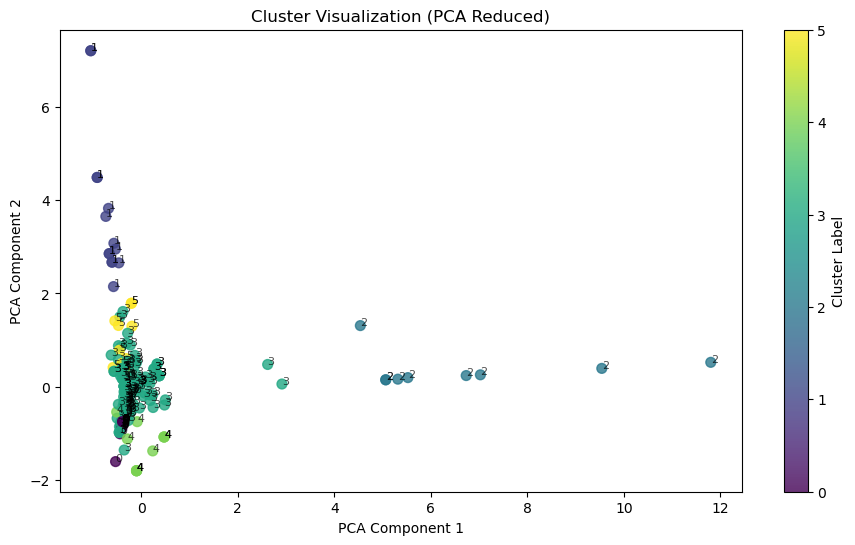

In [474]:
# Reduce to 2 dimensions using PCA and plot
pca = PCA(n_components=2)
R_hat_2d = pca.fit_transform(R_hat) 

plt.figure(figsize=(11, 6))
scatter = plt.scatter(R_hat_2d[:, 0], R_hat_2d[:, 1], c=labels, cmap='viridis', s=50, alpha=0.8)
plt.colorbar(scatter, label='Cluster Label')
plt.title('Cluster Visualization (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

for i, txt in enumerate(labels):
    plt.annotate(txt, (R_hat_2d[i, 0], R_hat_2d[i, 1]), fontsize=8, alpha=0.7)

plt.show()

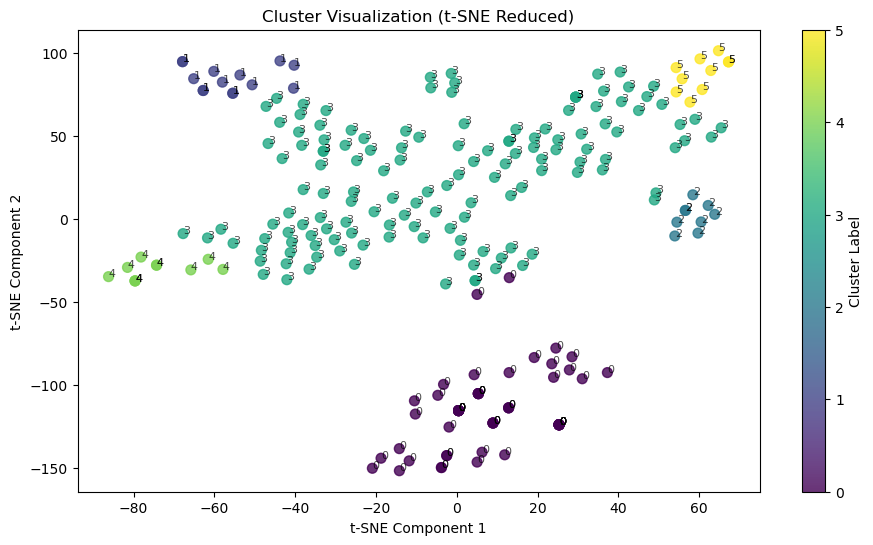

In [475]:
# Reduce to 2 dimensions using TSNE and plot
tsne = TSNE(n_components=2, random_state=0)
R_hat_2d_tsne = tsne.fit_transform(R_hat)

plt.figure(figsize=(11, 6))
plt.scatter(R_hat_2d_tsne[:, 0], R_hat_2d_tsne[:, 1], c=labels, cmap='viridis', s=50, alpha=0.8)

for i, txt in enumerate(labels):
    plt.annotate(txt, (R_hat_2d_tsne[i, 0], R_hat_2d_tsne[i, 1]), fontsize=8, alpha=0.7)

plt.colorbar(label='Cluster Label')
plt.title('Cluster Visualization (t-SNE Reduced)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

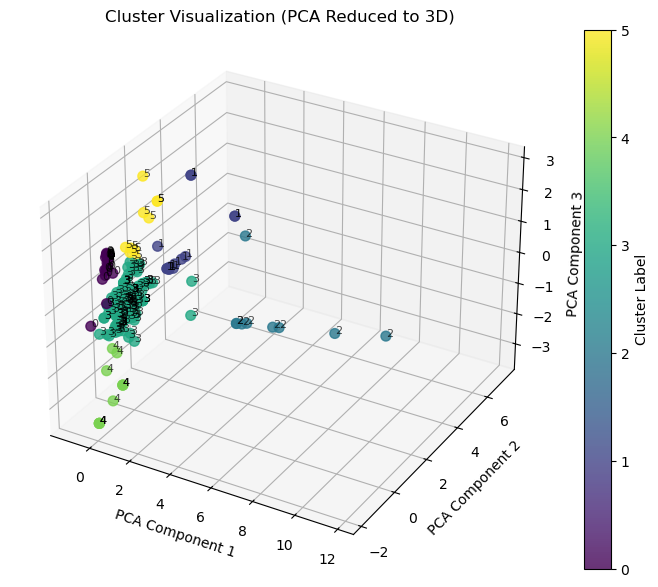

In [476]:
# Reduce to 3 dimensions using PCA
pca_3d = PCA(n_components=3)
R_hat_3d = pca_3d.fit_transform(R_hat)

# Create 3D plot
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(R_hat_3d[:, 0], R_hat_3d[:, 1], R_hat_3d[:, 2], c=labels, cmap='viridis', s=50, alpha=0.8)
plt.colorbar(scatter, label='Cluster Label')
ax.set_title('Cluster Visualization (PCA Reduced to 3D)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

for i, txt in enumerate(labels):
    ax.text(R_hat_3d[i, 0], R_hat_3d[i, 1], R_hat_3d[i, 2], str(txt), fontsize=8, alpha=0.7)

plt.show()